In [1]:
# Load the packages that are required
import numpy as np
import operator
import matplotlib.pyplot as plt

import sys
if sys.version_info < (3, 6):
    raise Exception('Please use Python version 3.6 or greater.')

try:
    import cplex
    from cplex.exceptions import CplexError
except: 
    print("Warning: Cplex not found.")
import math

# Qiskit packages
from qiskit.quantum_info import Pauli
from qiskit.aqua.input import EnergyInput
from qiskit.aqua import run_algorithm
from qiskit.aqua.operators import WeightedPauliOperator

# setup aqua logging
import logging
from qiskit.aqua._logging import set_logging_config, build_logging_config
#set_logging_config(build_logging_config(logging.DEBUG))  # choose INFO, DEBUG to see the log

In [2]:
# Initialize the problem by defining the parameters
n = 3  # number of nodes + depot (n+1)
K = 2  # number of vehicles

In [3]:
# Get the data
class Initializer():

    def __init__(self, n):
        self.n = n

    def generate_instance(self):

        n = self.n

        # np.random.seed(33)
        np.random.seed(1543)

        xc = (np.random.rand(n) - 0.5) * 10
        yc = (np.random.rand(n) - 0.5) * 10

        instance = np.zeros([n, n])
        for ii in range(0, n):
            for jj in range(ii + 1, n):
                instance[ii, jj] = (xc[ii] - xc[jj]) ** 2 + (yc[ii] - yc[jj]) ** 2
                instance[jj, ii] = instance[ii, jj]

        return xc, yc, instance

In [4]:
# Initialize the problem by randomly generating the instance
initializer = Initializer(n)
xc,yc,instance = initializer.generate_instance()

In [5]:
class ClassicalOptimizer:

    def __init__(self, instance,n,K):

        self.instance = instance
        self.n = n  # number of nodes
        self.K = K  # number of vehicles


    def compute_allowed_combinations(self):
        f = math.factorial
        return f(self.n) / f(self.K) / f(self.n-self.K)


    def cplex_solution(self):

        # refactoring
        instance = self.instance
        n = self.n
        K = self.K

        my_obj = list(instance.reshape(1, n**2)[0])+[0. for x in range(0,n-1)]
        my_ub = [1 for x in range(0,n**2+n-1)]
        my_lb = [0 for x in range(0,n**2)] + [0.1 for x in range(0,n-1)]
        my_ctype = "".join(['I' for x in range(0,n**2)]) + "".join(['C' for x in range(0,n-1)])

        my_rhs = 2*([K] + [1 for x in range(0,n-1)]) + [1-0.1 for x in range(0,(n-1)**2-(n-1))] + [0 for x in range(0,n)]
        my_sense = "".join(['E' for x in range(0,2*n)]) + "".join(['L' for x in range(0,(n-1)**2-(n-1))])+"".join(['E' for x in range(0,n)])

        try:
            my_prob = cplex.Cplex()
            self.populatebyrow(my_prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs)

            my_prob.solve()

        except CplexError as exc:
            print(exc)
            return

        x = my_prob.solution.get_values()
        x = np.array(x)
        cost = my_prob.solution.get_objective_value()

        return x,cost
    

    def populatebyrow(self,prob,my_obj,my_ub,my_lb,my_ctype,my_sense,my_rhs):

        n = self.n
    
        prob.objective.set_sense(prob.objective.sense.minimize)
        prob.variables.add(obj = my_obj, lb = my_lb, ub = my_ub, types = my_ctype)
    
        prob.set_log_stream(None)
        prob.set_error_stream(None)
        prob.set_warning_stream(None)
        prob.set_results_stream(None)

        rows = []
        for ii in range(0,n):
            col = [x for x in range(0+n*ii,n+n*ii)]
            coef = [1 for x in range(0,n)]
            rows.append([col, coef])

        for ii in range(0,n):
            col = [x for x in range(0+ii,n**2,n)]
            coef = [1 for x in range(0,n)]

            rows.append([col, coef])

        # Sub-tour elimination constraints:
        for ii in range(0, n):
            for jj in range(0,n):
                if (ii != jj)and(ii*jj>0):

                    col = [ii+(jj*n), n**2+ii-1, n**2+jj-1]
                    coef = [1, 1, -1]

                    rows.append([col, coef])

        for ii in range(0,n):
            col = [(ii)*(n+1)]
            coef = [1]
            rows.append([col, coef])

        prob.linear_constraints.add(lin_expr=rows, senses=my_sense, rhs=my_rhs)

In [6]:
# Instantiate the classical optimizer class
classical_optimizer = ClassicalOptimizer(instance,n,K)

# Print number of feasible solutions
print('Number of feasible solutions = ' + str(classical_optimizer.compute_allowed_combinations()))

Number of feasible solutions = 3.0


In [7]:
# Solve the problem in a classical fashion via CPLEX
x = None
z = None
try:
    x,classical_cost = classical_optimizer.cplex_solution()
    # Put the solution in the z variable
    z = [x[ii] for ii in range(n**2) if ii//n != ii%n]
    # Print the solution
    print(z)
except: 
    print("CPLEX may be missing.")

CPLEX may be missing.


In [8]:
# Visualize the solution
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)

    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()    

if x: visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [9]:
class QuantumOptimizer:

    def __init__(self, instance, n, K, max_trials=1000):

        self.instance = instance
        self.n = n
        self.K = K
        self.max_trials = max_trials

    def binary_representation(self,x_sol=0):

        instance = self.instance
        n = self.n
        K = self.K

        A = np.max(instance) * 100  # A parameter of cost function

        # Determine the weights w
        instance_vec = instance.reshape(n ** 2)
        w_list = [instance_vec[x] for x in range(n ** 2) if instance_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for ii in range(len(w_list)):
            w[ii] = w_list[ii]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for ii in range(n):
            count = ii-1
            for jj in range(n*(n-1)):

                if jj//(n-1) == ii:
                    count = ii

                if jj//(n-1) != ii and jj%(n-1) == count:
                    v[ii][jj] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q,g,c,cost

    def construct_hamiltonian(self):

        instance = self.instance
        n = self.n
        K = self.K

        N = (n - 1) * n  # number of qubits
        Q,g,c,_ = self.binary_representation()

        # Defining the new matrices in the Z-basis

        Iv = np.ones(N)
        Qz = (Q / 4)
        gz = (-g / 2 - np.dot(Iv, Q / 4) - np.dot(Q / 4, Iv))
        cz = (c + np.dot(g / 2, Iv) + np.dot(Iv, np.dot(Q / 4, Iv)))

        cz = cz + np.trace(Qz)
        Qz = Qz - np.diag(np.diag(Qz))

        # Getting the Hamiltonian in the form of a list of Pauli terms

        pauli_list = []
        for i in range(N):
            if gz[i] != 0:
                wp = np.zeros(N)
                vp = np.zeros(N)
                vp[i] = 1
                pauli_list.append((gz[i], Pauli(vp, wp)))
        for i in range(N):
            for j in range(i):
                if Qz[i, j] != 0:
                    wp = np.zeros(N)
                    vp = np.zeros(N)
                    vp[i] = 1
                    vp[j] = 1
                    pauli_list.append((2 * Qz[i, j], Pauli(vp, wp)))

        pauli_list.append((cz, Pauli(np.zeros(N), np.zeros(N))))

        return cz, pauli_list

    def check_hamiltonian(self):

        cz, op = self.construct_hamiltonian()
        Op = WeightedPauliOperator(paulis=op)

        qubitOp, offset = Op, 0
        algo_input = EnergyInput(qubitOp)

        # Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

        algorithm_cfg = {
            'name': 'ExactEigensolver',
        }

        params = {
            'problem': {'name': 'ising'},
            'algorithm': algorithm_cfg
        }
        result = run_algorithm(params, algo_input)

        quantum_solution = self._q_solution(result['eigvecs'][0],self.n*(self.n+1))
        ground_level = result['energy'] + offset

        return quantum_solution, ground_level

    def vqe_solution(self):

        cz, op = self.construct_hamiltonian()
        Op = WeightedPauliOperator(paulis=op)

        qubitOp, offset = Op, cz
        algo_input = EnergyInput(qubitOp)


        algorithm_cfg = {
            'name': 'VQE'
        }

        optimizer_cfg = {
            'name': 'SPSA',
            'max_trials': self.max_trials
        }

        var_form_cfg = {
            'name': 'RY',
            'depth': 5,
            'entanglement': 'linear'
        }

        params = {
            'problem': {'name': 'ising', 'random_seed': 10598},
            'algorithm': algorithm_cfg,
            'optimizer': optimizer_cfg,
            'variational_form': var_form_cfg,
            'backend': {'name': 'qasm_simulator'
                        }
        }

        result = run_algorithm(params, algo_input)

        #quantum_solution = self._q_solution(result['eigvecs'][0], self.n * (self.n + 1))
        quantum_solution_dict = result['eigvecs'][0]

        q_s = max(quantum_solution_dict.items(), key=operator.itemgetter(1))[0]
        quantum_solution= [int(chars) for chars in q_s]
        quantum_solution = np.flip(quantum_solution, axis=0)

        _,_,_,level = self.binary_representation(x_sol=quantum_solution)
        return quantum_solution_dict, quantum_solution, level

    def _q_solution(self, v, N):

        index_value = [x for x in range(len(v)) if v[x] == max(v)][0]
        string_value = "{0:b}".format(index_value)

        while len(string_value)<N:
            string_value = '0'+string_value

        sol = list()
        for elements in string_value:
            if elements == '0':
                sol.append(0)
            else:
                sol.append(1)

        sol = np.flip(sol, axis=0)

        return sol

In [10]:
# Instantiate the quantum optimizer class with parameters: 
quantum_optimizer = QuantumOptimizer(instance, n, K, 100)

In [11]:
# Check if the binary representation is correct
try:
    if z:
        Q,g,c,binary_cost = quantum_optimizer.binary_representation(x_sol = z)
        print(binary_cost,classical_cost)
        if np.abs(binary_cost - classical_cost)<0.01:
            print('Binary formulation is correct')
        else: print('Error in the binary formulation')
    else:
        print('Could not verify the correctness, due to CPLEX solution being unavailable.')
        Q,g,c,binary_cost = quantum_optimizer.binary_representation()
except NameError as e:
    print("Warning: Please run the cells above first.")
    print(e)

Could not verify the correctness, due to CPLEX solution being unavailable.


In [12]:
ground_state, ground_level = quantum_optimizer.check_hamiltonian()
print(ground_state)

if z:
    if np.abs(ground_level - classical_cost)<0.01:
        print('Ising Hamiltonian in Z basis is correct')
    else: print('Error in the Ising Hamiltonian formulation')

[1 1 1 0 1 0 0 0 0 0 0 0]


In [13]:
quantum_dictionary, quantum_solution, quantum_cost = quantum_optimizer.vqe_solution()

print(quantum_solution, quantum_cost)

[1 1 1 0 1 0] 132.11148115684045


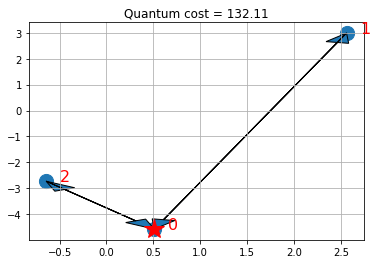

In [14]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1


# visualize the solution 
visualize_solution(xc, yc, x_quantum, quantum_cost, n, K, 'Quantum')
                   
# and visualize the classical for comparison
if x: visualize_solution(xc, yc, x, classical_cost, n, K, 'Classical')

In [15]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.translators.ising.vehicle_routing import *

qubitOp = get_vehiclerouting_qubitops(instance, n, K)
backend = BasicAer.get_backend('statevector_simulator')
seed = 50
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
result = vqe.run(quantum_instance)
# print(result)
x_quantum2 = get_vehiclerouting_solution(instance, n, K, result)
print(x_quantum2)
quantum_cost2 = get_vehiclerouting_cost(instance, n, K, x_quantum2)
print(quantum_cost2)

[1 1 1 0 0 1]
12434.909288240102


In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright